In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('vader_lexicon')
from nltk import word_tokenize, sent_tokenize, pos_tag, pos_tag_sents
import gensim
import gensim.corpora as corpora
import gensim.models.ldamodel as ldamodel
from gensim.summarization import summarize
import pyLDAvis.gensim
import seaborn as sns
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.probability import FreqDist
from IPython.utils.text import columnize
import warnings
warnings.filterwarnings("ignore")
import textwrap
%matplotlib notebook
plt.style.use('seaborn-darkgrid')



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/janetngocho/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
#source of iso code database: https://unstats.un.org/unsd/methodology/m49/overview/
#data set represents country names with their 3-letter ISO-alpha
# To convert the ISO codes into country names, performed a left join
#dataset also includes region(continent) to enable filtering of African countries
data = pd.read_csv('un-general-debates.csv').drop('session', axis=1)
country_names = pd.read_excel('UNSD — Methodology.xlsx')
data = pd.merge(data, country_names[['Region Name','Country or Area','ISO-alpha3 Code']],
             how='left', left_on='country', right_on='ISO-alpha3 Code')
data.drop('ISO-alpha3 Code',axis=1, inplace=True) #removing a duplicate column
data.head()

,year,country,text,Region Name,Country or Area
0,1989,MDV,﻿It is indeed a pleasure for me and the member...,Asia,Maldives
1,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ...",Europe,Finland
2,1989,NER,"﻿\nMr. President, it is a particular pleasure ...",Africa,Niger
3,1989,URY,﻿\nDuring the debate at the fortieth session o...,Americas,Uruguay
4,1989,ZWE,﻿I should like at the outset to express my del...,Africa,Zimbabwe


In [3]:
data = data.loc[data.year > 2000]
data = data.loc[data['Region Name'] == 'Africa']
# 3) Removing countries absent from any debates this century:
always_present = [index for (index,value) in 
                      data.country.value_counts().items() 
                  if value==15] # for 15 debates in the 21st century
data = data.loc[data['country'].isin(always_present)]

# The reduced dataframe (number of unique values per column):
data.nunique()

year                15
country             42
text               630
Region Name          1
Country or Area     42
dtype: int64

In [4]:
# Preparing texts for analysis:
def preprocessText(text):
    text = re.sub('[^a-z]+',' ', text.lower()) # remove all non-letter characters
    tokens = word_tokenize(text) # returns a list of individual words
    # Removing unhelpfull, ubiquitous words ('stop words', e.g. ‘the’, ‘is’, ‘are’):
    tokens = [token for token in tokens if len(token) > 4 and
             token not in nltk.corpus.stopwords.words('english')]
    # Lemmatizing removes inflectional endings and gets the root word (lemma):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmas

data['lemmatized_tokens'] = data['text'].apply(preprocessText)
data['lemmatized_tokens'].head()
data['lemmatized_text'] = [' '.join(x) for x in data['lemmatized_tokens']]
data['freq_dist'] = data['lemmatized_tokens'].apply(FreqDist)
data[['text','lemmatized_tokens','lemmatized_text']].head()


,text,lemmatized_tokens,lemmatized_text
228,Allow me to congratulate \nPresident Ashe on h...,"[allow, congratulate, president, election, pre...",allow congratulate president election preside ...
232,"At the outset, \nI would like, on behalf of th...","[outset, would, behalf, state, government, peo...",outset would behalf state government people co...
234,It is with a heavy heart that \nI address the ...,"[heavy, heart, address, assembly, today, ghana...",heavy heart address assembly today ghana atten...
244,It is an honour and a privilege \nfor me to on...,"[honour, privilege, address, south, africa, at...",honour privilege address south africa attache ...
249,"At the outset, I wish to congratulate \nHis Ex...","[outset, congratulate, excellency, election, p...",outset congratulate excellency election presid...


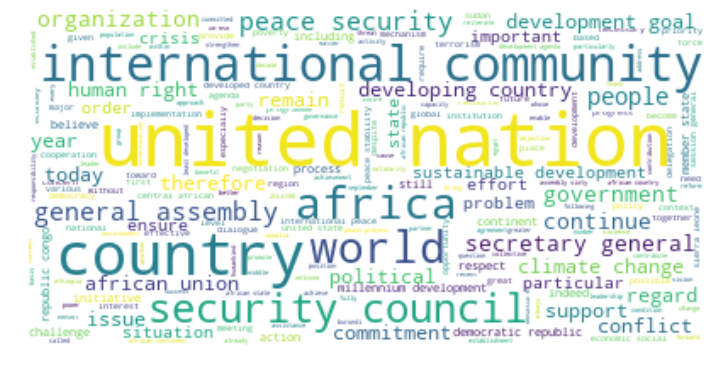

In [5]:
#african_map =np.genfromtxt('africa map.odg',delimiter=',', dtype='uint8')


text = data.lemmatized_text.sum()

#Plotting:
fig = plt.figure(figsize = (10,10))

wordcloud = WordCloud(background_color='white',
                      #mask=african_map,
                      max_words=2000).generate(text);
plt.imshow(wordcloud, interpolation='bilinear') # plotting the image
plt.axis("off")

plt.tight_layout()

In [6]:
# For each word count in how many documents does it appear:

texts = data.lemmatized_tokens.tolist() # I will be working on lemmatized words
all_words = list(set(data.lemmatized_tokens.sum())) # All unique words

texts = [list(set(t)) for t in texts] # Unique words in each text
word_in_texts = {} # keys=unique words, values=the number of texts in which they appear
for word in all_words:
    word_in_texts[word] = 0 
    for text in texts:
        if word in text:
            word_in_texts[word] += 1


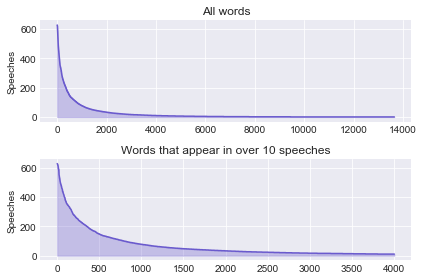

In [7]:

no_of_speeches = len(texts)

fig, ax = plt.subplots(nrows=2, ncols=1) # figure with two subplots

# converting the dicrionary to a list of tupples and sorting them from most common,
# to rarest words
wit = sorted(list(word_in_texts.items()), key=lambda x: x[1], reverse=True)
# for plotting: numbering words from most to liest common:
x_wit = [x for x in range(len(wit))]
y_wit = [y for (x,y) in wit]
ax[0].plot(x_wit, y_wit, color='slateblue')
ax[0].fill_between(x_wit, y_wit, color="slateblue", alpha=0.3)
ax[0].set_title('All words')
ax[0].set_ylabel('Speeches')

# very few words appear in most documents
# on the other hand out of >14,000 unique words
# about 10,000 occur in no more than 10 documents

wit_10 = [x for x in wit if x[1]>10] # remove words appearing in 10 or less documents
x_wit_10 = [x for x in range(len(wit_10))]
y_wit_10 = [y for (x,y) in wit_10]
ax[1].plot(x_wit_10, y_wit_10, color='slateblue')
ax[1].fill_between(x_wit_10, y_wit_10, color="slateblue", alpha=0.3)
ax[1].set_title('Words that appear in over 10 speeches')
ax[1].set_ylabel('Speeches')
plt.tight_layout()

In [8]:
print(columnize([str(x) for x in wit_10[0::25]])) # for a prettier display,
# I put the list into multiple columns

('nation', 627)          ('devoted', 54)         ('deliberate', 21)    
('election', 540)        ('chairman', 53)        ('beijing', 20)       
('social', 473)          ('continental', 52)     ('settled', 20)       
('problem', 421)         ('reduced', 51)         ('swiftly', 20)       
('responsibility', 374)  ('ultimate', 50)        ('abandoned', 19)     
('indeed', 346)          ('operational', 49)     ('revive', 19)        
('remain', 324)          ('rising', 48)          ('proposes', 19)      
('capacity', 300)        ('construction', 47)    ('valid', 18)         
('behalf', 277)          ('responding', 46)      ('borne', 18)         
('resolve', 259)         ('entrusted', 45)       ('simple', 18)        
('terrorist', 246)       ('farmer', 44)          ('announcement', 18)  
('million', 232)         ('rejection', 43)       ('peacemaking', 18)   
('another', 222)         ('fruitful', 43)        ('eritrean', 17)      
('light', 211)           ('applaud', 42)         ('motivated', 1

In [9]:
#LDA model

def find_topics(no_above, no_below, num_topics, data_frame):
    texts = data_frame['lemmatized_tokens'].tolist()
    id2word = corpora.Dictionary(texts)
    # ignore words with document frequency > than the given threshold
    # keep tokens which are contained in at least no_below documents
    id2word.filter_extremes(no_above=no_above, no_below=no_below)
    # Gensim creates a unique id for each word.
    # The produced corpus is a mapping of (word_id, word_frequency).
    corpus = [id2word.doc2bow(text) for text in texts]
    
    # Estimating LDA model parameters on the corpus.
    lda = ldamodel.LdaModel(corpus, num_topics=num_topics,passes=50, random_state=0,id2word=id2word)
    return lda, corpus, id2word

In [10]:
# The results are very sensitive to the number o topics, with some unintuitional results.
# 14 topics may e.g. give more similar results to 11 topics, than to 13.
# The results are also hugely sensitive to no_above. Including ubiquitous words resulted in
# pretty much just one topic, simmilar to the peace dove picture, repeted in different
# variations. As I played with the parameters, I captured a lot of interesting topics,
# but unfortunatelly never all of them at once.

num_topics = 12
lda_30, corpus_30, id2word_30 = find_topics(0.3, 10, num_topics, data)
for topic in lda_30.show_topics():
    print('topic', topic[0])
    print(textwrap.fill(topic[1], 75))



topic 3
0.019*"senegal" + 0.010*"verde" + 0.006*"sahel" + 0.006*"islamic" +
0.006*"religion" + 0.005*"mediation" + 0.004*"young" + 0.004*"civilization"
+ 0.004*"water" + 0.004*"guinea"
topic 10
0.052*"sierra" + 0.049*"leone" + 0.012*"mozambique" + 0.010*"ebola" +
0.005*"peacebuilding" + 0.005*"court" + 0.005*"subregion" + 0.005*"liberia"
+ 0.004*"outbreak" + 0.004*"continued"
topic 11
0.007*"burundi" + 0.004*"niger" + 0.003*"benin" + 0.003*"undertaken" +
0.002*"lake" + 0.002*"disarmament" + 0.002*"subregion" + 0.002*"ivoire" +
0.002*"hope" + 0.002*"fifty"
topic 2
0.023*"gabon" + 0.012*"namibia" + 0.010*"forest" + 0.009*"emission" +
0.008*"copenhagen" + 0.008*"environmental" + 0.007*"greenhouse" +
0.006*"kyoto" + 0.006*"zambia" + 0.005*"drought"
topic 9
0.036*"guinea" + 0.016*"burkina" + 0.015*"algeria" + 0.015*"equatorial" +
0.004*"sahara" + 0.004*"sovereignty" + 0.004*"dispute" + 0.004*"equitable"
+ 0.003*"demand" + 0.003*"mediation"
topic 8
0.007*"tanzania" + 0.005*"nuclear" + 0.005*

In [11]:
# I wished to know which topics does each of our speeches contain.
# Here, I create a dataframe with the list of topics contributing to each speech in
# one column ('topics'), and the main topic in another column ('main topic')

def text_topics(ldamodel, corpus):
    topics_df = data.drop(['country','text','Region Name'], axis=1, inplace=False)
    topics_df['topics'] = [sorted(ldamodel.get_document_topics(corpus[i]), 
                               key=lambda x: x[1], reverse=True) 
                        for i in range(data.shape[0])]
    topics_df['Main topic'] = [x[0][0] for x in topics_df.topics]   
    return topics_df

In [12]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_30, corpus_30, id2word_30)
vis



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.019778 -0.011431       1        1  29.650206
4      0.045785  0.008044       2        1  15.560796
0     -0.049496 -0.022721       3        1  12.225258
8      0.052971 -0.000836       4        1  11.308367
7      0.007077 -0.115102       5        1   6.073896
9     -0.084801  0.025243       6        1   5.030838
3     -0.118038  0.048640       7        1   4.963397
6     -0.022538  0.023348       8        1   4.241838
2      0.107999  0.201415       9        1   3.333901
10     0.055868 -0.069795      10        1   3.114951
5     -0.127348 -0.010423      11        1   2.533627
1      0.152298 -0.076381      12        1   1.962924, topic_info=     Category        Freq        Term       Total  loglift  logprob
term                                                               
1810  Default  367.000000      sierra  367.000000  30.0000  30.0000
1796  Default  345.000000       leone  345.000000  29.0000  29.0000
336   Default  510.000000      guinea  510.000000  28.0000  28.0000
2300  Default  377.000000    ethiopia  377.000000  27.0000  27.0000
639   Default  336.000000      ivoire  336.000000  26.0000  26.0000
2661  Default  297.000000      angola  297.000000  25.0000  25.0000
662   Default  251.000000     nigeria  251.000000  24.0000  24.0000
1694  Default  267.000000   mauritius  267.000000  23.0000  23.0000
1680  Default  317.000000      island  317.000000  22.0000  22.0000
2690  Default  241.000000     eritrea  241.000000  21.0000  21.0000
584   Default  301.000000       egypt  301.000000  20.0000  20.0000
2337  Default  269.000000     tunisia  269.000000  19.0000  19.0000
1322  Default  192.000000       gabon  192.000000  18.0000  18.0000
2975  Default  203.000000     senegal  203.000000  17.0000  17.0000
1337  Default  325.000000     morocco  325.000000  16.0000  16.0000
2887  Default  163.000000     comoros  163.000000  15.0000  15.0000
2618  Default  208.000000    tanzania  208.000000  14.0000  14.0000
2445  Default  197.000000     burkina  197.000000  13.0000  13.0000
2852  Default  178.000000     algeria  178.000000  12.0000  12.0000
2359  Default  154.000000  equatorial  154.000000  11.0000  11.0000
999   Default  171.000000     namibia  171.000000  10.0000  10.0000
1835  Default  473.000000     burundi  473.000000   9.0000   9.0000
127   Default  226.000000      malawi  226.000000   8.0000   8.0000
950   Default  215.000000      zambia  215.000000   7.0000   7.0000
710   Default  398.000000     somalia  398.000000   6.0000   6.0000
2257  Default  154.000000  mozambique  154.000000   5.0000   5.0000
1683  Default  375.000000     kingdom  375.000000   4.0000   4.0000
3027  Default  135.000000       verde  135.000000   3.0000   3.0000
1320  Default  150.000000      france  150.000000   2.0000   2.0000
477   Default  275.000000   subregion  275.000000   1.0000   1.0000
...       ...         ...         ...         ...      ...      ...
2673  Topic12    5.464595  impediment   25.927643   2.3737  -6.6149
1316  Topic12   10.406303     federal   49.467793   2.3718  -5.9708
2618  Topic12   37.382141    tanzania  208.095596   2.2139  -4.6920
1326  Topic12   19.244429     illicit  131.402863   2.0097  -5.3560
2315  Topic12    4.900943     interim   24.962618   2.3028  -6.7238
2100  Topic12   12.453072    genocide   81.337082   2.0541  -5.7912
3672  Topic12    5.490443       newly   29.127567   2.2621  -6.6102
2337  Topic12   27.586060     tunisia  269.258179   1.6524  -4.9959
1287  Topic12   14.066670     binding  108.915154   1.8840  -5.6694
1357  Topic12   15.565159     renewed  140.229843   1.7325  -5.5682
1932  Topic12    7.001432      menace   41.942024   2.1406  -6.3671
494   Topic12   12.939816    transfer  124.282066   1.6685  -5.7529
1403  Topic12   13.396003      ecowas  139.217896   1.5897  -5.7183
2110  Topic12   13.927310      rwanda  153.306488   1.5321  -5.6794
1273 

In [13]:
def text_topics(ldamodel, corpus):
    topics_df = data.drop(['country','text','Region Name'], axis=1, inplace=False)
    topics_df['topics'] = [sorted(ldamodel.get_document_topics(corpus[i]), 
                               key=lambda x: x[1], reverse=True) 
                        for i in range(data.shape[0])]
    topics_df['Main topic'] = [x[0][0] for x in topics_df.topics]   
    return topics_df

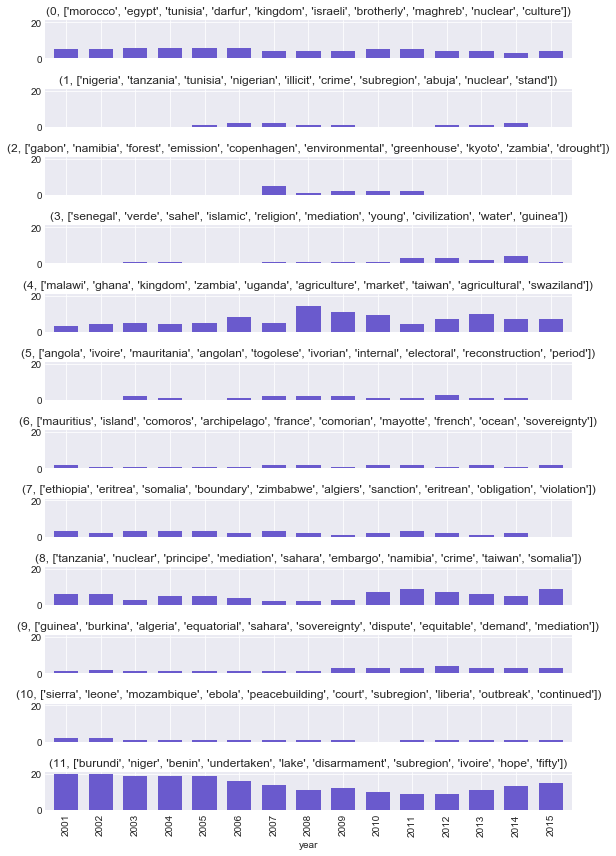

In [14]:

       
# Did topic distribution change over years?
# Did any topics become more/less popular?
# For each topic I counted in how many speeches was it the main one
# in each year.
# Although the counts fluctuate from year to year, and topic 9 clearly
# peaks in 2008, non of the topics suddenly appears or dissapears
# within the time frame. I wonder whether this is an artifact of the
# method or representation of facts?

def plot_by_year(ldamodel, corpus):
    topics_df = text_topics(ldamodel, corpus)
    
    # Listing words contribution to each topic for the
    # purpose of graph labelling:
    topics = ldamodel.show_topics(formatted=False, num_topics=num_topics)
    topics_words = [(tp[0], [wd[0] for wd in tp[1]])[:] for tp in topics]
    
    # A dataframe with years as rows and each topic as a column.
    # The value in row x and column y is the number of speeches in year x
    # with main topic y.
    df1 = pd.crosstab(topics_df['year'], topics_df['Main topic'])
    df1.plot.bar(subplots=True, sharey=True, figsize=(9,12),
            use_index=True, legend=False, title=topics_words,
            color='slateblue', width=0.7)
    plt.tight_layout()

plot_by_year(lda_30, corpus_30)


In [15]:



# I will need to split each speech into sentences.
# For compatibility with my lists of words,
# I lowercased and lemmatized all words in sentences.
def to_sentences_lemmas(text):
    sentences = sent_tokenize(text.lower()) # returns a list of sentences
    # Lemmatize each word:
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmas = [[lemmatizer.lemmatize(word) for word in word_tokenize(sentence)]
              for sentence in sentences]
    return lemmas

# a list of sentences in which each sentence is itself a list:
data['sentences_lemmas'] = data.text.apply(to_sentences_lemmas)
# a list of sentences in a continous form:
data['sentences'] = data.text.str.replace('\n+',' ').apply(sent_tokenize)
data[['sentences_lemmas','sentences']].head()




,sentences_lemmas,sentences
228,"[[allow, me, to, congratulate, president, ashe...",[Allow me to congratulate President Ashe on h...
232,"[[at, the, outset, ,, i, would, like, ,, on, b...","[At the outset, I would like, on behalf of th..."
234,"[[it, is, with, a, heavy, heart, that, i, addr...",[It is with a heavy heart that I address the ...
244,"[[it, is, an, honour, and, a, privilege, for, ...",[It is an honour and a privilege for me to on...
249,"[[at, the, outset, ,, i, wish, to, congratulat...","[At the outset, I wish to congratulate His Ex..."


In [16]:
# I think that shortening the text tenfold seems a good compromise between
# reducing the length and retaining information.
# This will give me mostly 5-10 sentence summaries.

def summarize(x):
    m = x['freq_dist'].most_common(1)[0][1] # get the highest count
    scores = [sum([x['freq_dist'][word]/m for word in sentence]
                 ) for sentence in x['sentences_lemmas']]
    indexes = [i for i in range(len(scores))]
    zipped = list(zip(scores,indexes))
    zipped = sorted(zipped, key=lambda x: x[0], reverse=True)
    # how many sentences to return?
    n = int(len(indexes)/10)
    # get the index of sentences with n highest scores:
    i = [zipped[item][1] for item in range(n)]
    return [x['sentences'][index] for index in i]

data['summary'] = data.apply(summarize, axis=1)

In [17]:
# Let's see how well it worked:
print(data.iloc[3]['year'], data.iloc[3]['Country or Area'])
print('\nOriginal lemmatized text:', str(len(data.iloc[3]['sentences'])), 'sentences')
for sentence in data.iloc[3]['sentences']:
    print(textwrap.fill(sentence, 75))
print('\nSummary:', str(len(data.iloc[3]['summary'])), 'sentences')
for sentence in data.iloc[3]['summary']:
    print(textwrap.fill(sentence, 75))

2013 South Africa

Original lemmatized text: 67 sentences
It is an honour and a privilege  for me to once again address this body.
South Africa  attaches the utmost importance to the General Assembly  as
the most representative and democratic organ of the  United Nations serving
the international community.
We congratulate President Ashe and the Republic of  Antigua and Barbuda on
his election as President of the  General Assembly at its sixty-eighth
session.
We also  thank Mr. Vuk Jeremi.
for the splendid way in which he  presided over the Assembly at its sixty-
seventh session.
Let me begin by reiterating our condemnation of  the horrific terrorist
attack over the weekend in Kenya,  in which a number of civilians,
including a South  African national, were killed.
We express our deepest  condolences to the Government and people of Kenya
and to all those families who lost loved ones, and wish  the wounded
survivors a speedy recovery.
We continue  to support the efforts of Kenya and the

In [18]:
# The analyser returns a dictionary of scores, in the form:
# {'neg': 0.152, 'neu': 0.848, 'pos': 0.0, 'compound': -0.5267}
# 'compound' represents the general sentiment of each sentence.
# Each word in the lexicon is associated with a strength of sentiment,
# and this information is reflected in the 'compound' score.

def strongest_sentiments(text):
    analyser = SentimentIntensityAnalyzer()
    scores = [analyser.polarity_scores(sentence)['compound'] for sentence in text]
    indexes = [i for i in range(len(scores))]
    zipped = list(zip(scores,indexes))
    zipped_positive = sorted(zipped, key=lambda x: x[0], reverse=True)
    zipped_negative = sorted(zipped, key=lambda x: x[0], reverse=False)
    # how many sentences to return?
    n = int(len(indexes)/250)
    # get the index of sentences with n highest scores:
    most_positive = [zipped_positive[item][1] for item in range(n)]
    most_negative = [zipped_negative[item][1] for item in range(n)]
    return [text[index] for index in most_positive], [text[index] 
                                                      for index in most_negative]

all_sentences = data.sentences.sum()
positive , negative = strongest_sentiments(all_sentences)

In [19]:
for sentence in positive[:10]:
    print(textwrap.fill(sentence, 75), '\n')

Each party shall respect the border so determined, as well as the
territorial integrity and sovereignty of the other party.” Thirdly,
regarding punitive measures that should be taken against the violating
party, paragraph 14 of the Cessation of Hostilities Agreement (S/2000/601,
annex) states: “[The] OAU and the United Nations commit themselves to
guarantee the respect for this commitment of the two parties until the
determination of the common border … This guarantee shall be comprised of
a) Measures to be taken by the international community should one or both
of the parties violate this commitment, including appropriate measures to
be taken under Chapter VII of the Charter of the United Nations by the
United Nations Security Council.” It has been more than two years now since
the Boundary Commission announced its decision on the basis of the Algiers
Peace Agreement. 

It gives us great satisfaction to note that Ethiopia is now the second-
largest contributor of troops to United Nati

In [20]:
# ten most negative sentences
for sentence in negative[:10]:
    print(textwrap.fill(sentence, 75), '\n')

If we were to list them, although not  exhaustively, we could mention the
current economic  and financial crisis, which triggered the most serious
social crisis witnessed to date by our generation; a  dangerous
environmental crisis of unpredictable  consequences for the future of
humankind, which will  be irreversible unless the international community
as a  whole applies immediate and courageous measures;  and a general
escalation of violence and outbreak of  conflict, which, combined with the
environmental  crisis, has caused the most serious humanitarian crisis
that humankind has witnessed since the end of the  Second World War. 

While our country has made significant progress in the area of security and
counter- terrorism — particularly through the defeat of many terrorist
plans and other criminal activities and the arrest of many suspects who
were then prosecuted — over the course of this past year, we have
nonetheless been the victims of two heinous terrorist attacks targeting t

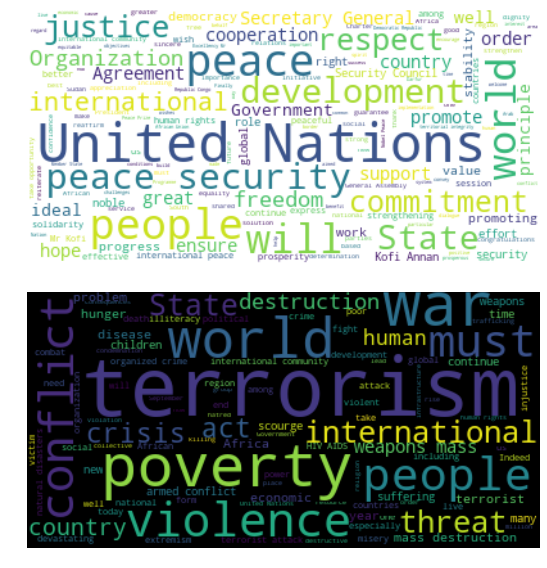

In [21]:
# And a visual...
text_positive = ' '.join(positive)
text_negative = ' '.join(negative)

# Plotting:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
wordcloud_positive = WordCloud(background_color='white',
                      max_words=2000).generate(text_positive);
ax[0].imshow(wordcloud_positive, interpolation='bilinear')
ax[0].axis("off")

wordcloud_negative = WordCloud(background_color='black',
                      max_words=2000).generate(text_negative);
ax[1].imshow(wordcloud_negative, interpolation='bilinear')
ax[1].axis("off")

plt.tight_layout()